# Integrating Functional Data

So far most of our work has been examining anatomical images - the reason being is that it provides a nice visual way of exploring the effects of data manipulation and visualization is easy. In practice, you will most likely not analyze anatomical data using <code>nilearn</code> since there are other tools that are better suited for that kind of analysis (freesurfer, connectome-workbench, mindboggle, etc...). 

In this notebook we'll finally start working with functional MR data - the modality of interest in this workshop. First we'll cover some basics about how the data is organized (similar to T1s but slightly more complex), and then how we can integrate our anatomical and functional data together using tools provided by <code>nilearn</code>

Functional data consists of full 3D brain volumes that are *sampled* at multiple time points. Therefore you have a sequence of 3D brain volumes, stepping through sequences is stepping through time and therefore time is our 4th dimension! Here's a visualization to make this concept more clear:

<img src="./static/images/4D_array.png" alt="Drawing" align="middle" width="500px"/>

Each index along the 4th dimensions (called TR for "Repetition Time", or Sample) is a full 3D scan of the brain. Pulling out volumes from 4-dimensional images is similar to that of 3-dimensional images except you're now dealing with:


<code> nimg.slicer[x,y,z,time] </code>!

Let's try a couple of examples to familiarize ourselves with dealing with 4D images. But first, let's pull some functional data using PyBIDS!

In [3]:
import os
import matplotlib.pyplot as plt #to enable plotting within notebook
from nilearn import image as nimg
from nilearn import plotting as nplot
from bids.layout import BIDSLayout
import numpy as np
%matplotlib inline

These are the usual imports. Let's now pull some structural *and* functional data using pyBIDS.

We'll be using functional files in MNI space rather than T1w space. Recall, that MNI space data is data that was been warped into standard space. These are the files you would typically use for a group-level functional imaging analysis!

In [4]:
fmriprep_dir = '../data/ds000030/derivatives/fmriprep/'
layout=BIDSLayout(fmriprep_dir, validate=False,
                  config=['bids','derivatives'])

T1w_files = layout.get(subject='10788',
                       datatype='anat', desc='preproc',
                       space='MNI152NLin2009cAsym',
                       extension="nii.gz",
                      return_type='file')

brainmask_files = layout.get(subject='10788',
                             datatype='anat', suffix='mask',
                             desc='brain',
                             space='MNI152NLin2009cAsym',
                             extension="nii.gz",
                            return_type='file')

func_files = layout.get(subject='10788',
                        datatype='func', desc='preproc',
                       space='MNI152NLin2009cAsym',
                       extension="nii.gz",
                       return_type='file')

func_mask_files = layout.get(subject='10788',
                             datatype='func', suffix='mask',
                             desc='brain',
                             space='MNI152NLin2009cAsym',
                             extension="nii.gz",
                            return_type='file')

/home/jerry/.pyenv/versions/3.7.0/envs/sdc-bids-fmri/lib/python3.7/site-packages/bids/layout/models.py:102: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


In [5]:
func_mni = func_files[0]
func_mni_img = nimg.load_img(func_mni)

## fMRI Dimensions

First note that fMRI data contains both spatial dimensions (x,y,z) and a temporal dimension (t). This would mean that we require 4 dimensions in order to represent our data. Let's take a look at the shape of our data matrix to confirm this intuition:


In [4]:
func_mni_img.shape

(65, 77, 49, 152)

Notice that the Functional MR scan contains *4 dimensions*. This is in the form of $(x,y,z,t)$, where $t$ is time. 
We can use slicer as usual where instead of using 3 dimensions we use 4. 

For example:

<code> func.slicer[x,y,z] </code> 

vs.

<code> func.slicer[x,y,z,t] </code>

### Exercise

Try pulling out the 5th TR and visualizing it using <code>nplot.view_img</code>.

Remember that <code>nplot.view_img</code> provides an interactive view of the brain, try scrolling around!

/home/jerry/.pyenv/versions/3.7.0/envs/sdc-bids-fmri/lib/python3.7/site-packages/nilearn/plotting/html_stat_map.py:83: UserWarning: Threshold given was 1e-06, but the data has no values below -98.74230194091797. 
  data.min()))



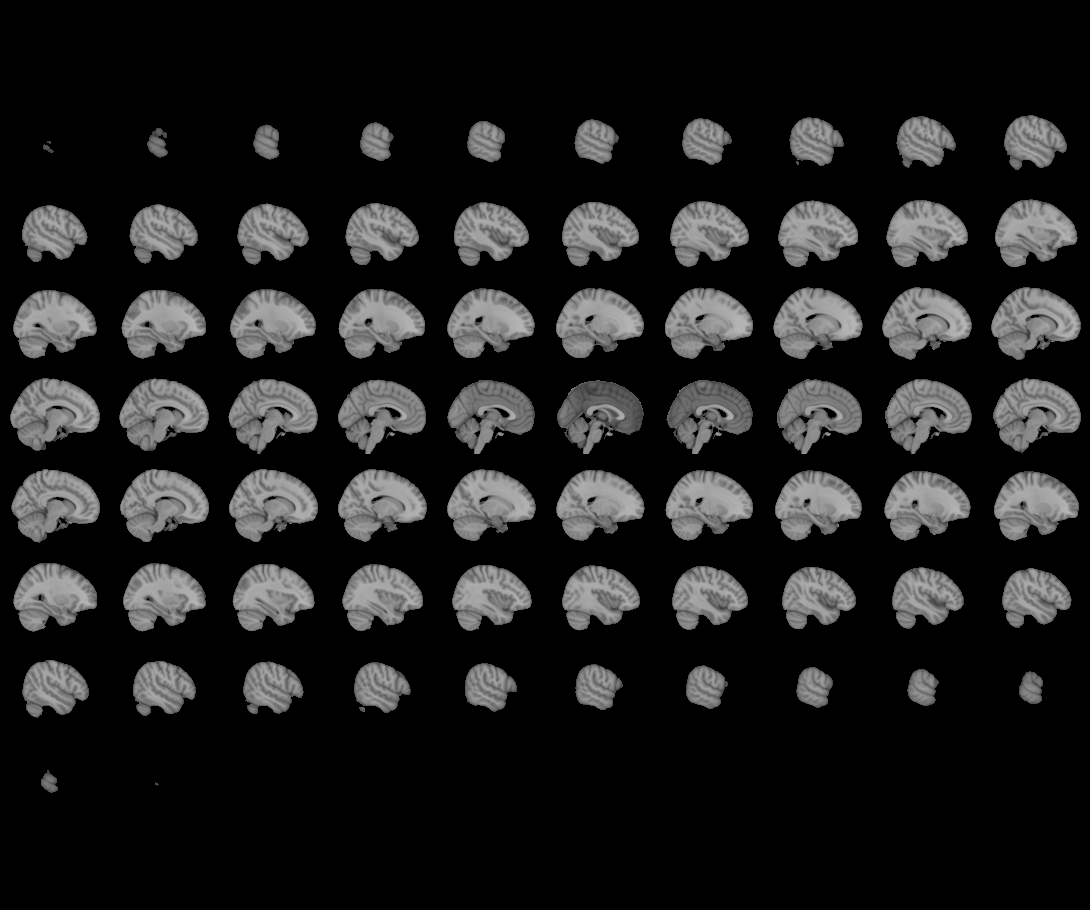
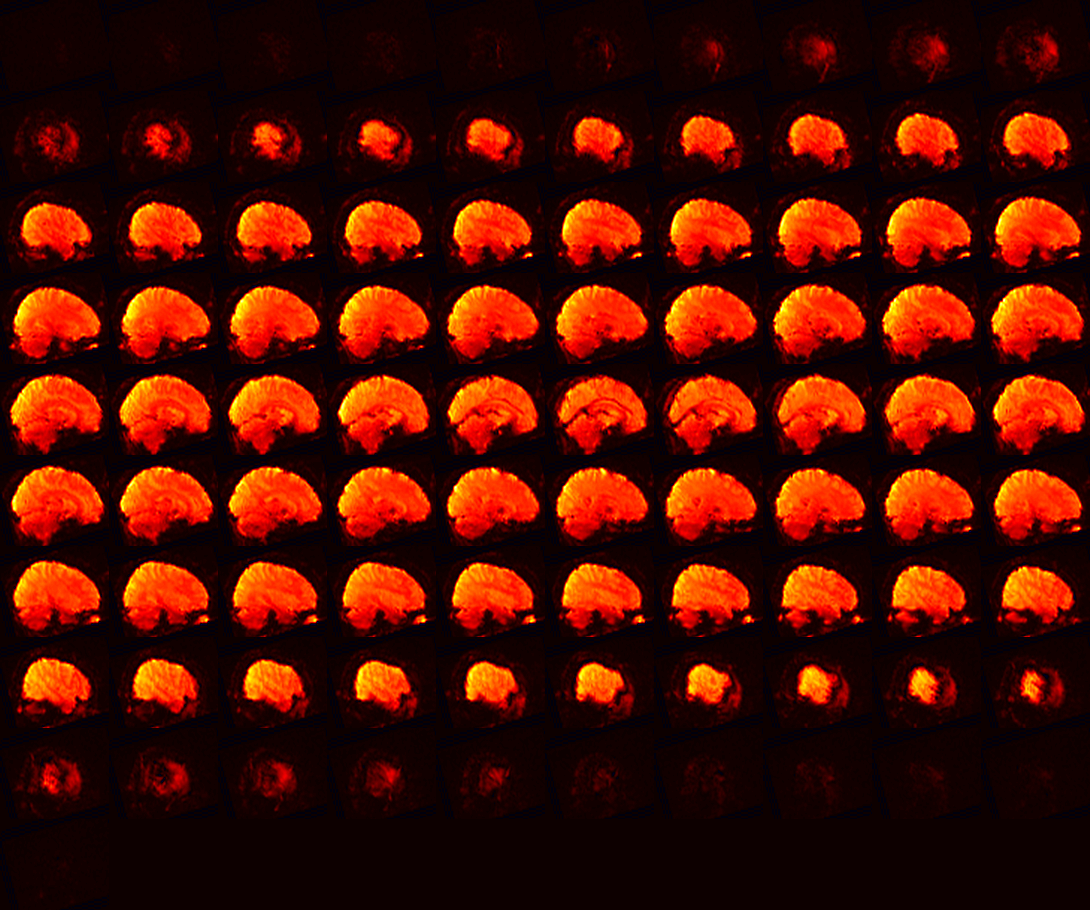

In [6]:
#Pull the 5th TR
func_vol5 = func_mni_img.slicer[:,:,:,4]
nplot.view_img(func_vol5)

You may also use <code>nplot.plot_epi</code>. <code>plot_epi</code> is exactly the same as <code>plot_anat</code> except it displays using colors that make more sense for functional images...

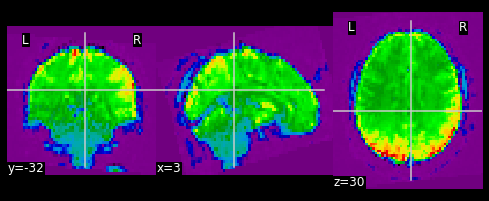

In [7]:
#Pull the 5th TR
nplot.plot_epi(func_vol5)

## What fMRI actually represents

We've represented fMRI as a snapshot of MR signal over multiple timepoints. This is a useful way of understanding the organization of fMRI, however it isn't typically how we think about the data when we analyze fMRI data. fMRI is typically thought of as **time-series** data. We can think of each voxel (x,y,z coordinate) as having a time-series of length T. The length T represents the number of volumes/timepoints in the data. Let's pick an example voxel and examine its time-series using <code>func_mni_img.slicer</code>:

In [8]:
#Pick one voxel at coordinate (60,45,88)
single_vox = func_mni_img.slicer[59:60,45:46,30:31,:].get_data()
single_vox.shape

/home/jerry/.pyenv/versions/3.7.0/envs/sdc-bids-fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


(1, 1, 1, 152)

As you can see we have 1 element in (x,y,z) dimension representing a single voxel. In addition, we have 152 elements in the fourth dimension. In totality, this means we have a single voxel with 152 timepoints. Dealing with 4 dimensional arrays are difficult to work with - since we have a single element across the first 3 dimensions we can squish this down to a 1 dimensional array with 152 time-points. We no longer need the first 3 spatial dimensions since we're only looking at one voxel and don't need (x,y,z) anymore:


In [10]:
single_vox = single_vox.flatten()
single_vox.shape

(152,)

Here we've pulled out a voxel at a specific coordinate at every single time-point. This voxel has a single value for each timepoint and therefore is a time-series. We can visualize this time-series signal by using a standard python plotting library. We won't go into too much detail about python plotting, the intuition about what the data looks like is what is most important:

First let's import the standard python plotting library <code>matplotlib</code>:


In [10]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Signal Value')

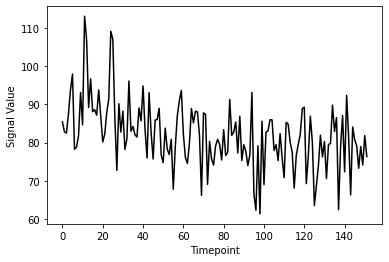

In [11]:
# Make an array counting from 0 --> 152, this will be our x-axis
x_axis = np.arange(0, single_vox.shape[0])

# Plot our x and y data, the 'k' just specifies the line color to be black
plt.plot( x_axis, single_vox, 'k')

# Label our axes
plt.xlabel('Timepoint')
plt.ylabel('Signal Value')


As you can see from the image above, fMRI data really is just a signal per voxel over time!


## Resampling
Recall from our introductory exploration of neuroimaging data:

- T1 images are typically composed of voxels that are 1x1x1 in dimension
- Functional images are typically composed of voxels that are 4x4x4 in dimension

If we'd like to overlay our functional on top of our T1 (for visualization purposes, or analyses), then we need to match the size of the voxels! 

Think of this like trying to overlay a 10x10 JPEG and a 20x20 JPEG on top of each other. To get perfect overlay we need to resize (or more accurately *resample*) our JPEGs to match!

**Note**: 
Resampling is a method of interpolating in between data-points. When we stretch an image we need to figure out what goes in the spaces that are created via stretching - resampling does just that. In fact, resizing any type of image is actually just resampling to new dimensions. 

Let's resampling some MRI data using nilearn. 

**Goal**: Match the dimensions of the structural image to that of the functional image

In [12]:
# Files we'll be using (Notice that we're using _space-MNI...
# which means they are normalized brains)
T1_mni = T1w_files[0]
T1_mni_img = nimg.load_img(T1_mni)

Let's take a look at the sizes of both our functional and structural files:

In [13]:
print(T1_mni_img.shape)
print(func_mni_img.shape)

(193, 229, 193)
(65, 77, 49, 152)


Taking a look at the spatial dimensions (first three dimensions), we can see that the number of voxels in the T1 image does not match that of the fMRI image. This is because the fMRI data (which has less voxels) is a *lower resolution image*. We either need to *upsample* our fMRI image to match that of the T1 image, or we need to *downsample* our T1 image to match that of the fMRI image. Typically, since the fMRI data is the one we'd like to ultimately use for analysis, we would leave it alone and downsample our T1 image. The reason being is that *resampling* requires interpolating values which may contaminate our data with artifacts. We don't mind having artifacts in our T1 data (for visualization purposes) since the fMRI data is the one actually being analyzed.


Resampling in nilearn is as easy as telling it which image you want to sample and what the target image is.

Structure of function:

<code>nimg.resample_to_img(source_img,target_img,interpolation)</code>
- <code>source_img</code> = the image you want to sample
- <code>target_img</code> = the image you wish to *resample to* 
- <code>interpolation</code> = the method of interpolation

A note on **interpolation**

nilearn supports 3 types of interpolation, the one you'll use depends on the type of data you're resampling!
1. **continuous** - Interpolate but maintain some edge features.  Ideal for structural images where edges are well-defined. Uses $3^\text{rd}$-order spline interpolation.
2. **linear (default)** - Interpolate uses a combination of neighbouring voxels - will blur. Uses trilinear interpolation.
3. **nearest** - matches value of closest voxel (majority vote from neighbours). This is ideal for masks which are binary since it will preserve the 0's and 1's and will not produce in-between values (ex: 0.342). Also ideal for numeric labels where values are 0,1,2,3... (parcellations). Uses nearest-neighbours interpolation with majority vote.


(65, 77, 49)
(65, 77, 49, 152)


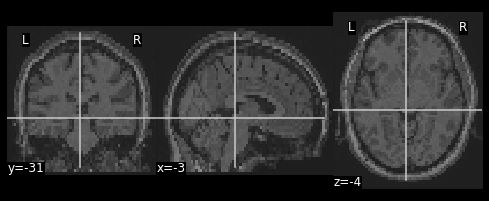

In [14]:
#Try playing around with methods of interpolation
#options: 'linear','continuous','nearest'
resamp_t1 = nimg.resample_to_img(source_img=T1_mni_img,target_img=func_mni_img,interpolation='continuous')
print(resamp_t1.shape)
print(func_mni_img.shape)
nplot.plot_anat(resamp_t1)

In [15]:
import matplotlib.animation
from IPython.display import HTML

In [16]:
%%capture
%matplotlib inline
#Resample the T1 to the size of the functional image!
resamp_t1 = nimg.resample_to_img(source_img=T1_mni_img, target_img=func_mni_img, interpolation='continuous')
fig, ax = plt.subplots()

def animate(image):
    nplot.plot_anat(image, figure=fig, cut_coords=(0,0,0))
    ax.set_facecolor('black')
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=[resamp_t1, T1_mni_img]) 
#change the frames to look at the functional mask over the resampled T1
# ani = matplotlib.animation.FuncAnimation(fig, animate, frames=[resamp_t1, func]) 

In [17]:
# Display animation
HTML(ani.to_jshtml())

/home/jerry/.pyenv/versions/3.7.0/envs/sdc-bids-fmri/lib/python3.7/site-packages/nilearn/plotting/displays.py:618: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = figure.add_axes(axes)
/home/jerry/.pyenv/versions/3.7.0/envs/sdc-bids-fmri/lib/python3.7/site-packages/nilearn/plotting/displays.py:1110: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  .3 * (x1 - x0), y1 - y0], aspect='equal')


Now that we've explored the idea of resampling let's do a cumulative exercise bringing together ideas from resampling and basic image operations.


## **Exercise**

Using the T1 and Resting state functional image do the following:
1. Resample the T1 image to resting state size
2. Replace the brain in the T1 image with the first frame of the resting state brain

In [12]:
#Files we'll need


####STRUCTURAL FILES

#T1 image
ex_t1 = nimg.load_img(T1w_files[0])

#mask file
ex_t1_bm = nimg.load_img(brainmask_files[0])


####FUNCTIONAL FILES

# fMRI image
ex_func = nimg.load_img(func_files[0])

# fMRI mask image
ex_func_bm = nimg.load_img(func_mask_files[0])

The first step is to remove the brain from the T1 image so that we're left with a hollow skull. This can be broken down into 2 steps:

1. Invert the mask so that all 1's become 0's and all 0's become 1's

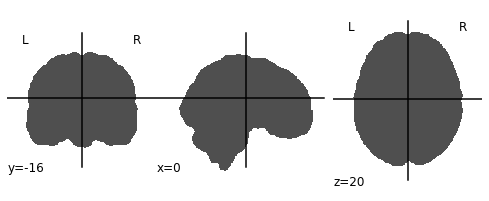

In [19]:
# Invert the mask
invert_mask = nimg.math_img('1-a', a=ex_t1_bm)
nplot.plot_anat(invert_mask)

2. Apply the mask onto the T1 image, this will effectively remove the brain

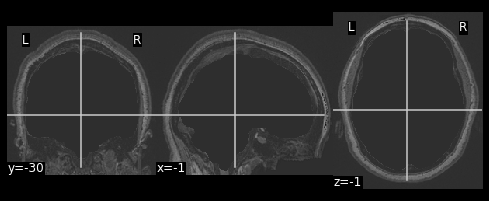

In [20]:
# Apply the mask onto the T1 image
hollow_skull = nimg.math_img("a*b", a=ex_t1, b=invert_mask)
nplot.plot_anat(hollow_skull)

Our brain is now missing!

Next we need to *resize* the hollow skull image to the dimensions of our resting state image. This can be done using resampling as we've done earlier in this episode.

What kind of interpolation would we need to perform here? Recall that:
- **Continuous**: Tries to maintain the edges of the image
- **Linear**: Resizes the image but also blurs it a bit
- **Nearest**: Sets values to the closest neighbouring values

(65, 77, 49)
(65, 77, 49, 152)


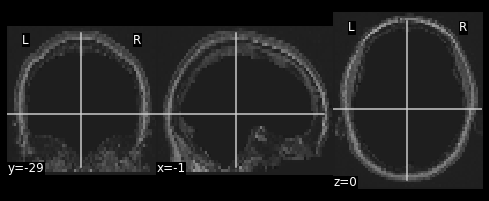

In [21]:
#Resample the T1 to the size of the functional image!
resamp_skull = nimg.resample_to_img(source_img=hollow_skull,
                                 target_img=ex_func,
                                 interpolation='continuous')
nplot.plot_anat(resamp_skull)
print(resamp_skull.shape)
print(ex_func.shape)

We now have a skull missing the structural T1 brain that is resized to match the dimensions of the EPI image.

The final steps are to:
1. Pull the first volume from the functional image
2. Place the functional image head into the hollow skull that we've created

Since a functional image is 4-Dimensional, we'll need to pull the first volume to work with. This is because the structural image is 3-dimensional and operations will fail if we try to mix 3D and 4D data.

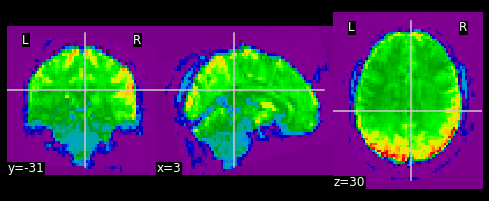

In [22]:
#Let's visualize the first volume of the functional image:
first_vol = ex_func.slicer[:,:,:,0]
nplot.plot_epi(first_vol)

As shown in the figure above, the image has some "signal" outside of the brain. In order to place this within the now brainless head we made earlier, we need to mask out the functional MR data as well!

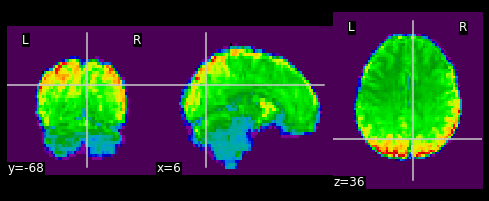

In [23]:
masked_func = nimg.math_img('a*b', a=first_vol, b=ex_func_bm)
nplot.plot_epi(masked_func)

The final step is to stick this data into the head of the T1 data. Since the hole in the T1 data is represented as $0$'s. We can add the two images together to place the functional data into the void:

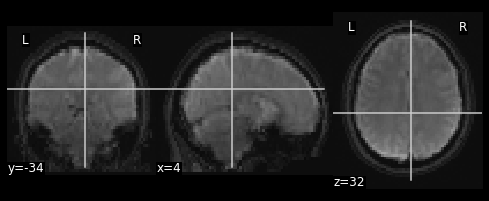

In [24]:
#Now overlay the functional image on top of the anatomical
combined_img = nimg.math_img('a+b',
                             a=resamp_skull, 
                             b=masked_func)
nplot.plot_anat(combined_img)

This doesn't actually achieve anything useful in practice. However it has hopefully served to get you more comfortable with the idea of resampling and performing manipulations on MRI data!

***

In this section we explored functional MR imaging. Specifically we covered:
    
1. How the data in a fMRI scan is organized - with the additional dimension of timepoints
2. How we can integrate functional MR images to our structural image using resampling
3. How we can just as easily manipulate functional images using <code>nilearn</code>

Now that we've covered all the basics, it's time to start working on data processing using the tools that we've picked up. 